<a href="https://colab.research.google.com/github/RajTejani61/Intern/blob/main/Deep%20Learning/GAN/Celebrity-Face-Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copy kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Optional: secure the file

In [2]:
#!/bin/bash
!kaggle datasets download jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98% 1.30G/1.33G [00:14<00:00, 39.1MB/s]
100% 1.33G/1.33G [00:14<00:00, 101MB/s] 


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/celeba-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [13]:
image_size = 64
batch_size = 128
latent_dim = 100
generator_feature_map = 64
discriminator_feature_map = 64
number_epochs = 5
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
transform = transforms.Compose([
	transforms.Resize(image_size),
	transforms.CenterCrop(image_size),
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
tainloader = datasets.ImageFolder(root='/content/img_align_celeba', transform=transform)
dataloader = DataLoader(tainloader, batch_size=batch_size, shuffle=True)

In [8]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_dim, generator_feature_map*8, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(generator_feature_map*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_feature_map*8, generator_feature_map*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(generator_feature_map*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_feature_map*4, generator_feature_map*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(generator_feature_map*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_feature_map*2, generator_feature_map, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(generator_feature_map),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_feature_map, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self,  x):
    return self.main(x)

In [9]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, discriminator_feature_map, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(discriminator_feature_map, discriminator_feature_map*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(discriminator_feature_map*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(discriminator_feature_map*2, discriminator_feature_map*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(discriminator_feature_map*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(discriminator_feature_map*4, discriminator_feature_map*8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(discriminator_feature_map*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(discriminator_feature_map*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x).view(-1)

In [10]:
generator = Generator().to(device)
discrminator = Discriminator().to(device)

criterian = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discrminator.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device = device)

Epoch [1 / 5]Loss_Discrminator : 0.3724Loss_Generator : 5.3201
Epoch [2 / 5]Loss_Discrminator : 0.2602Loss_Generator : 4.2421
Epoch [3 / 5]Loss_Discrminator : 0.1283Loss_Generator : 3.2133
Epoch [4 / 5]Loss_Discrminator : 0.3455Loss_Generator : 6.1471
Epoch [5 / 5]Loss_Discrminator : 0.1394Loss_Generator : 4.1700


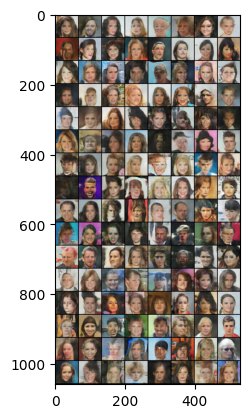

In [14]:
for epoch in range(number_epochs):
  for i, (data, _) in enumerate(dataloader):
    data = data.to(device)
    batch_size = data.size(0)

    real_label = torch.full((batch_size,), 1, device=device, dtype=torch.float)
    fake_label = torch.full((batch_size,), 0, device=device, dtype=torch.float)

    discrminator.zero_grad()

    real_data_output = discrminator(data)
    real_data_loss = criterian(real_data_output, real_label)

    z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    output = generator(z)
    fake_data_output = discrminator(output.detach())
    fake_data_loss = criterian(fake_data_output, fake_label)

    loss_D = real_data_loss + fake_data_loss
    loss_D.backward()
    optimizer_D.step()

    generator.zero_grad()
    fake_output = generator(z)
    discrminator_output = discrminator(fake_output)
    generator_loss = criterian(discrminator_output, real_label)
    generator_loss.backward()
    optimizer_G.step()

  print(f"Epoch [{epoch+1} / {number_epochs}]"
        f"Loss_Discrminator : {loss_D:.4f}"
        f"Loss_Generator : {generator_loss:.4f}")

with torch.no_grad():
  fake = generator(fixed_noise).detach().cpu()
  grid = torchvision.utils.make_grid(fake, padding=2, normalize=True)
  plt.imshow(grid.permute(1, 2, 0))
  plt.show()

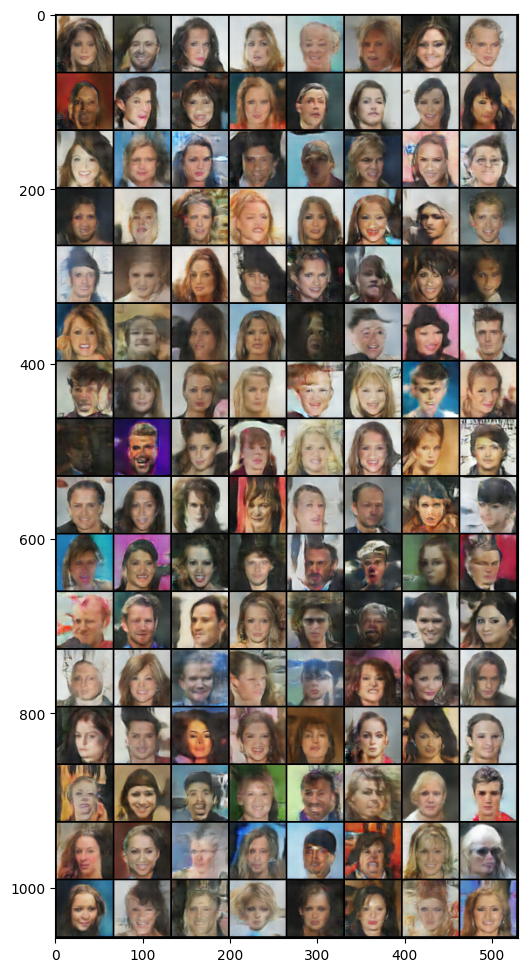

In [17]:
with torch.no_grad():
  fake = generator(fixed_noise).detach().cpu()
  grid = torchvision.utils.make_grid(fake, padding=2, normalize=True)
  plt.figure(figsize=(12, 12))
  plt.imshow(grid.permute(1, 2, 0))
  plt.show()